In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import h5py
from keras.callbacks import EarlyStopping

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import Dense,ReLU,MaxPool2D,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D,concatenate,add,GlobalAvgPool2D
from tensorflow.keras.models import Model,Sequential

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
data_path = "./TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info",mode = "r" )
with h5py.File(data_path, "r") as data:
    data_matrix = data["matrix"][:]

In [4]:
print("min intensity: ", data_info.Vmax.min(),", max intensity: ",data_info.Vmax.max(),", Average of intensity: ",round(data_info.Vmax.mean(),2))

min intensity:  15.0 , max intensity:  155.0 , Average of intensity:  48.14


In [5]:
data_info.head(10)

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0
5,ATLN,201701L,-48.2,34.0,2017041621,52.0,255.0,986.0
6,ATLN,201701L,-47.8,33.7,2017041700,50.0,255.0,987.0
7,ATLN,201701L,-47.4,33.5,2017041703,48.0,236.2,988.0
8,ATLN,201701L,-47.0,33.2,2017041706,45.0,217.5,988.0
9,ATLN,201701L,-46.5,33.0,2017041709,45.0,210.0,988.0


In [6]:
data_info[data_info['Vmax']<16].head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
376,ATLN,201709L,-84.7,38.2,2017090212,15.0,0.0,1013.0
487,ATLN,201711L,-88.1,34.8,2017091218,15.0,0.0,1003.0
488,ATLN,201711L,-88.5,35.2,2017091221,15.0,0.0,1004.0
489,ATLN,201711L,-88.9,35.6,2017091300,15.0,0.0,1004.0
490,ATLN,201711L,-89.2,35.9,2017091303,15.0,0.0,1004.0


In [7]:
data_info[data_info['Vmax']>154].head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
431,ATLN,201711L,-59.2,16.9,2017090518,155.0,122.5,926.0
432,ATLN,201711L,-59.9,17.1,2017090521,155.0,123.8,920.0
433,ATLN,201711L,-60.6,17.3,2017090600,155.0,125.0,915.0
434,ATLN,201711L,-61.2,17.5,2017090603,155.0,125.0,914.0
435,ATLN,201711L,-61.9,17.7,2017090606,155.0,125.0,914.0


In [8]:
data_matrix.shape

(4580, 201, 201, 4)

In [9]:
#cyclone image with low intensity using seaborn heatmap

<AxesSubplot: >

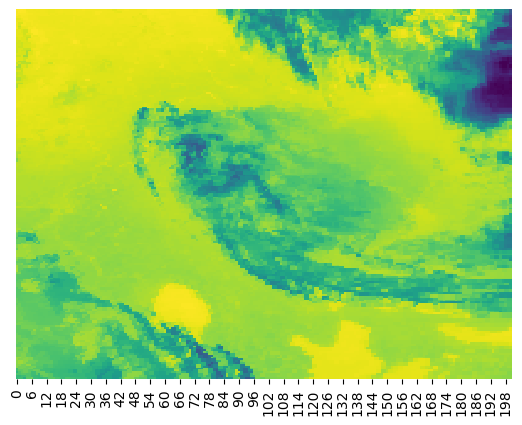

In [10]:
img = data_matrix[376,:,:,0].copy()
sns.heatmap(img,yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot: >

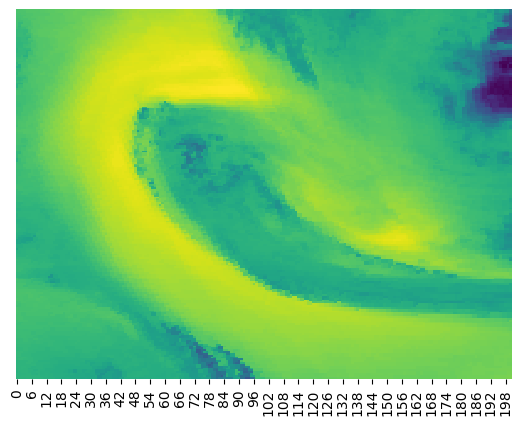

In [11]:
img = data_matrix[376,:,:,1].copy()
sns.heatmap(img,yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot: >

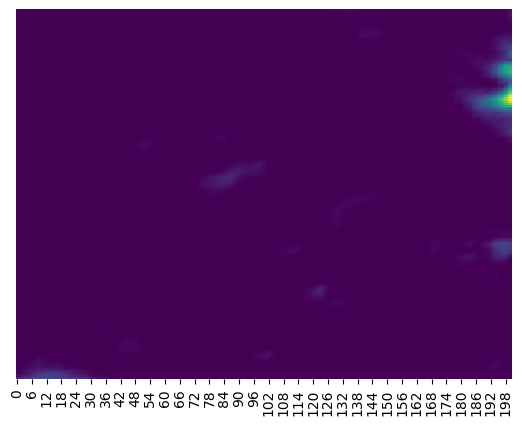

In [12]:
img = data_matrix[376,:,:,3].copy()
sns.heatmap(img,yticklabels=False,cbar=False,cmap='viridis')

In [13]:
#cyclone image with high intensity using matplotlib imshow function

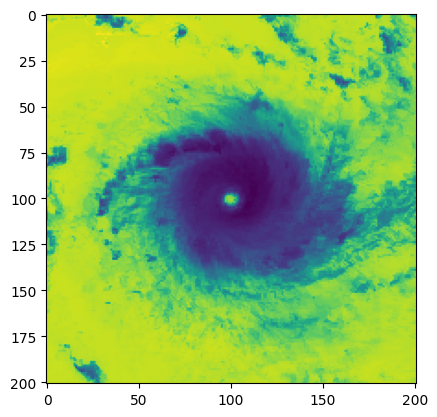

In [14]:
img = data_matrix[431,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img)

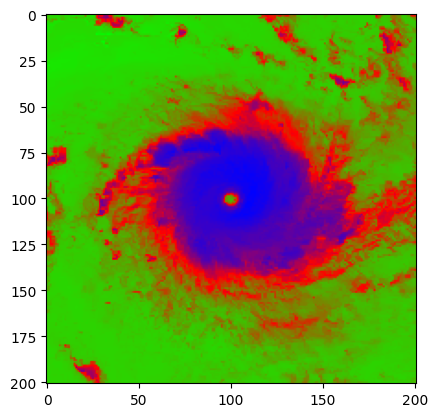

In [15]:
img = data_matrix[431,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.brg)

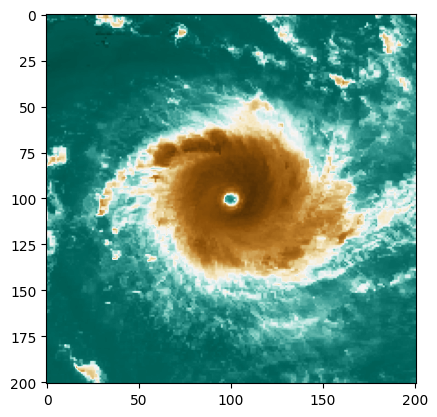

In [16]:
img = data_matrix[431,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.BrBG)

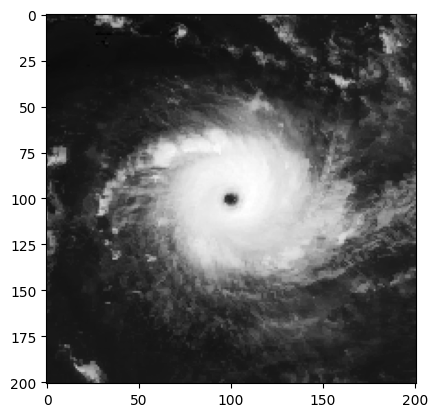

In [17]:
img = data_matrix[431,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.binary)

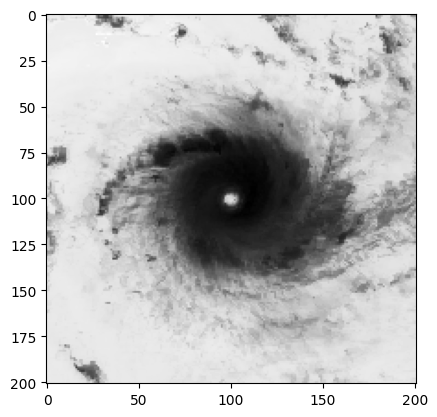

In [18]:
img = data_matrix[431,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

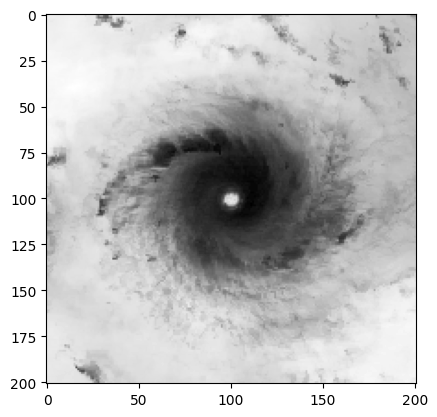

In [19]:
img = data_matrix[431,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

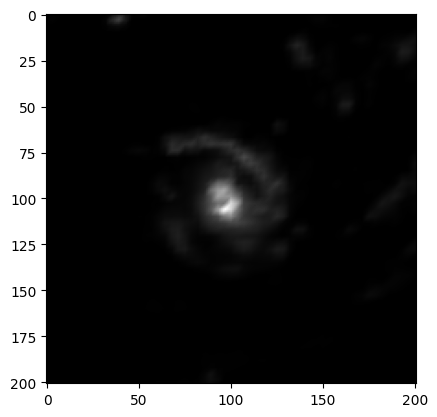

In [20]:
img = data_matrix[431,:,:,3].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [21]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time,format="%Y%m%d%H"))

In [22]:
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [23]:
a=[1,2,3,4,5]
a[0::3]

[1, 4]

In [24]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [25]:
X_irpmw.shape

(4580, 201, 201, 2)

In [26]:
class Preprocessing(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Preprocessing, self).__init__(**kwargs)
    def call(self,inputs,training=None):
        if training:
            inputs = tf.image.rot90(inputs,k=np.random.randint(4))
        return tf.image.central_crop(inputs,0.5)

In [19]:
def train_val_model(train_x,train_y,val_x,val_y,n_epochs,batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y= tf.convert_to_tensor(train_y)

    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)

    weights_initializer = keras.initializers.GlorotUniform()

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=96,kernel_size=(11,11),strides=4,padding='valid',activation='relu',input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3),strides=2),
        keras.layers.Conv2D(filters=256,kernel_size=(5,5),padding='same',activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3,3),strides=2),
        keras.layers.Conv2D(filters=384,kernel_size=(3,3),padding='same',activation='relu'),
        keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3,3),strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(4096,activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(4096,activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1,activation='relu'),

    ])

    early_stopping = EarlyStopping(monitor='mean_squared_error',min_delta=0,patience=3,verbose=1,restore_best_weights=True)
    callbacks_list =[early_stopping]

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4,beta_1=0.99,beta_2=0.9999),loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])
    history = model.fit(train_X,train_Y,epochs=n_epochs,batch_size=batch_size,verbose=1,callbacks=callbacks_list)
    val_score = model.evaluate(val_X,val_Y)
    print('Val Score: ',val_score)
    return history,val_score,model



In [27]:
train_x, val_x, train_y, val_y = train_test_split(X_irpmw,y, random_state=101,test_size=0.1)

train_x,test_x,train_y,test_y = train_test_split(train_x,train_y,random_state=101,test_size=0.1)



In [ ]:
history, val_score, model = train_val_model(train_x,train_y,val_x,val_y,50,256)

In [21]:
y_pred = model.predict(test_x)

score = model.evaluate(test_x,test_y,batch_size=16,verbose=1)


26/26 [==============================] - 1s 24ms/step - loss: 176.7456 - mean_squared_error: 176.7456 - mean_absolute_error: 10.4741


In [22]:
predicted_intensity = []
for i in y_pred:
    predicted_intensity.append(int(i))

categories = []
for j in predicted_intensity:
    if j<=33:
        categories.append('Tropical Depression')
    elif j>33 and j<=63:
        categories.append('Tropical Storm')
    elif j>63 and j<=129:
        categories.append('Typhon')
    elif j>129:
        categories.append('Super Typhon')


In [23]:
category_dataset = list(zip(predicted_intensity,categories))

predicted_dataset = pd.DataFrame(category_dataset,columns=['Intensity','Category'])

predicted_dataset.head(15)

,Intensity,Category
0,50,Tropical Storm
1,37,Tropical Storm
2,31,Tropical Depression
3,81,Typhon
4,32,Tropical Depression
5,35,Tropical Storm
6,56,Tropical Storm
7,43,Tropical Storm
8,40,Tropical Storm
9,169,Super Typhon


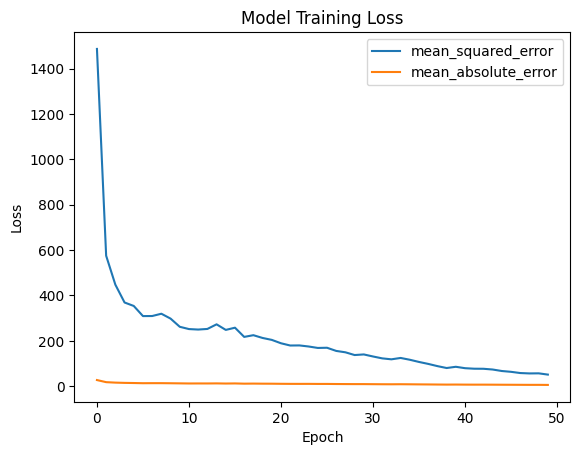

In [30]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['mean_squared_error','mean_absolute_error'], loc='upper right')
plt.show()

In [31]:
model.save('cyclone_intensity_model.h5')

In [20]:
model_loaded = tf.keras.models.load_model('cyclone_intensity_model.h5',custom_objects={'Preprocessing':Preprocessing()})

In [21]:
y_pred = model_loaded.predict(test_x)

score = model_loaded.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 1s 26ms/step - loss: 176.7456 - mean_squared_error: 176.7456 - mean_absolute_error: 10.4741


In [22]:
predicted_intensity = []
for i in y_pred:
    predicted_intensity.append(int(i))

categories = []
for j in predicted_intensity:
    if j<=33:
        categories.append('Tropical Depression')
    elif j>33 and j<=63:
        categories.append('Tropical Storm')
    elif j>63 and j<=129:
        categories.append('Typhon')
    elif j>129:
        categories.append('Super Typhon')


In [23]:
category_dataset = list(zip(predicted_intensity,categories))

predicted_dataset = pd.DataFrame(category_dataset,columns=['Intensity','Category'])

predicted_dataset.head(15)

,Intensity,Category
0,50,Tropical Storm
1,37,Tropical Storm
2,31,Tropical Depression
3,81,Typhon
4,32,Tropical Depression
5,35,Tropical Storm
6,56,Tropical Storm
7,43,Tropical Storm
8,40,Tropical Storm
9,169,Super Typhon


In [24]:
# Second Approach

In [25]:
#A function that trains and validates the model and returns the MSE
def model2(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    # train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    # val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error','mean_absolute_error'], #Computes the mean squared error between y_true and y_pred
                 )
    # initialize TimeStopping callback 
#     time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
         #callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model

In [26]:
# n_epochs=200
# batch_size=64
# model_history = []  #save the model history in a list after fitting so that we can plot later
# val_scores=[]
# kf = KFold(n_splits=5)

# i=0
# for train_index, test_index in kf.split(X_irpmw):
#     print("Training on Fold: ",i+1)
#     i+=1
#     train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
#     train_y, val_y = y[train_index], y[test_index]
#     history2,val_score2, secondmodel = model2(train_x,train_y,val_x,val_y, n_epochs, batch_size)
#     model_history.append(history2)
#     val_scores.append(val_score2)
#     print("======="*12, end="\n\n\n")

In [27]:
history2, val_score2, second_model = model2(train_x,train_y,val_x,val_y,200,64)

Epoch 1/200
53/53 [==============================] - 4s 35ms/step - loss: 3135.7974 - mean_squared_error: 3135.7913 - mean_absolute_error: 49.0638 - val_loss: 2662.1001 - val_mean_squared_error: 2662.0942 - val_mean_absolute_error: 45.1941
Epoch 2/200
53/53 [==============================] - 2s 30ms/step - loss: 3135.7944 - mean_squared_error: 3135.7913 - mean_absolute_error: 49.0638 - val_loss: 2662.0974 - val_mean_squared_error: 2662.0942 - val_mean_absolute_error: 45.1941
Epoch 3/200
53/53 [==============================] - 2s 29ms/step - loss: 2822.9932 - mean_squared_error: 2822.9912 - mean_absolute_error: 45.5705 - val_loss: 1739.7335 - val_mean_squared_error: 1739.7322 - val_mean_absolute_error: 38.0684
Epoch 4/200
53/53 [==============================] - 2s 30ms/step - loss: 1075.4969 - mean_squared_error: 1075.4956 - mean_absolute_error: 24.4313 - val_loss: 715.4641 - val_mean_squared_error: 715.4630 - val_mean_absolute_error: 21.0399
Epoch 5/200
53/53 [=======================

In [28]:
val_scores=[]
val_scores.append(val_score2)

In [29]:
val_scores

[[190.89768981933594, 190.8921356201172, 10.115472793579102]]

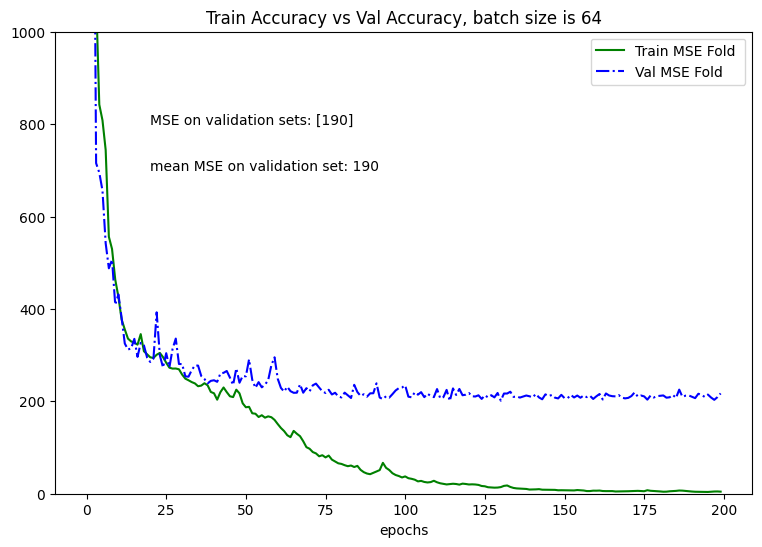

In [30]:
plt.figure(figsize=(9,6))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
# colors=['black','red','green','purple','orange']
# for i in range(5):
    # plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
    # plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")
plt.plot(history2.history['mean_squared_error'], label='Train MSE Fold ', color='green')
plt.plot(history2.history['val_mean_squared_error'], label='Val MSE Fold ', color='blue', linestyle = "dashdot")
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2,v3 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()

In [31]:
second_model.save('second_cyclone_intensity_model.h5')

In [32]:
loaded_model2 = tf.keras.models.load_model('second_cyclone_intensity_model.h5',custom_objects={'Preprocessing':Preprocessing()})

In [33]:
y_pred = loaded_model2.predict(test_x)

score = loaded_model2.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 0s 10ms/step - loss: 175.2477 - mean_squared_error: 175.2421 - mean_absolute_error: 9.6810


In [34]:
# Model 3

In [20]:
def model3(train_x,train_y,val_x,val_y,n_epochs,batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y= tf.convert_to_tensor(train_y)

    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    weights_initializer = keras.initializers.GlorotUniform()

    model = keras.models.Sequential([
        Preprocessing(),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3),  activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3,3),  activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3),  activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # # The fifth convolution
        tf.keras.layers.Conv2D(256, (3,3),  activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.Dense(256,activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
        tf.keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param))

    ])

    

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error','mean_absolute_error'])

    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1)
         
    val_score = model.evaluate(val_X,val_Y)
    print('Val Score: ',val_score)
    return history,val_score,model



In [21]:
history3, val_score3, third_model = model3(train_x,train_y,val_x,val_y,200,64)

Epoch 1/200
53/53 [==============================] - 9s 54ms/step - loss: 965.8296 - mean_squared_error: 965.8200 - mean_absolute_error: 23.9336 - val_loss: 717.2700 - val_mean_squared_error: 717.2609 - val_mean_absolute_error: 18.0967
Epoch 2/200
53/53 [==============================] - 2s 36ms/step - loss: 859.7088 - mean_squared_error: 859.7003 - mean_absolute_error: 22.5794 - val_loss: 663.9252 - val_mean_squared_error: 663.9171 - val_mean_absolute_error: 18.6129
Epoch 3/200
53/53 [==============================] - 2s 33ms/step - loss: 794.5007 - mean_squared_error: 794.4929 - mean_absolute_error: 21.5489 - val_loss: 777.1882 - val_mean_squared_error: 777.1806 - val_mean_absolute_error: 24.0977
Epoch 4/200
53/53 [==============================] - 2s 36ms/step - loss: 751.7938 - mean_squared_error: 751.7862 - mean_absolute_error: 21.2811 - val_loss: 700.4707 - val_mean_squared_error: 700.4634 - val_mean_absolute_error: 22.7162
Epoch 5/200
53/53 [==============================] - 2s 

In [22]:
y_pred = third_model.predict(test_x)

score = third_model.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 1s 14ms/step - loss: 138.4517 - mean_squared_error: 138.4436 - mean_absolute_error: 8.6857


In [23]:
third_model.save('third_cyclone_intensity_model.h5')

In [24]:
loaded_model3 = tf.keras.models.load_model('third_cyclone_intensity_model.h5',custom_objects={'Preprocessing':Preprocessing()})

In [25]:
y_pred = loaded_model3.predict(test_x)

score = loaded_model3.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 0s 9ms/step - loss: 138.4517 - mean_squared_error: 138.4436 - mean_absolute_error: 8.6857


In [21]:
# model 4 vgg

In [21]:

def model_vgg(train_x,train_y,val_x,val_y,n_epochs,batch_size):
    reg_param = 1e-5
    
    
    # train_X = train_x.reshape(train_x.shape[0], 201, 201, 2)
    # train_Y = train_y.reshape(train_y.shape[0], 201,201,2)

    train_X = tf.convert_to_tensor(train_x)
    train_Y= tf.convert_to_tensor(train_y)

    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    weights_initializer = keras.initializers.GlorotUniform()

    model = keras.models.Sequential([
        Preprocessing(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding="same", kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # The second convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding="same", kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding="same", kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # tf.keras.layers.Conv2D(256, (1,1), activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding="same", kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding="same", kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # tf.keras.layers.Conv2D(512, (1,1), activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # # The fifth convolution
        tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding="same", kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding="same", kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # tf.keras.layers.Conv2D(512, (1,1), activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        tf.keras.layers.Dense(256,activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
        tf.keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param))

    ])

    

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error','mean_absolute_error'])

    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1)
         
    val_score = model.evaluate(val_X,val_Y)
    print('Val Score: ',val_score)
    return history,val_score,model






In [22]:
history4, val_score4, vgg_model = model_vgg(train_x,train_y,val_x,val_y,200,64)

Epoch 1/200
53/53 [==============================] - 20s 179ms/step - loss: 2535.1047 - mean_squared_error: 2535.0710 - mean_absolute_error: 29.9839 - val_loss: 682.5947 - val_mean_squared_error: 682.5613 - val_mean_absolute_error: 18.6046
Epoch 2/200
53/53 [==============================] - 6s 119ms/step - loss: 844.8646 - mean_squared_error: 844.8317 - mean_absolute_error: 22.3013 - val_loss: 741.1075 - val_mean_squared_error: 741.0746 - val_mean_absolute_error: 18.0758
Epoch 3/200
53/53 [==============================] - 6s 119ms/step - loss: 940.0716 - mean_squared_error: 940.0390 - mean_absolute_error: 22.0354 - val_loss: 652.0271 - val_mean_squared_error: 651.9944 - val_mean_absolute_error: 19.3027
Epoch 4/200
53/53 [==============================] - 6s 119ms/step - loss: 744.9210 - mean_squared_error: 744.8881 - mean_absolute_error: 21.1258 - val_loss: 660.1157 - val_mean_squared_error: 660.0825 - val_mean_absolute_error: 17.7862
Epoch 5/200
53/53 [==============================

In [23]:
y_pred = vgg_model.predict(test_x)

score = vgg_model.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 2s 52ms/step - loss: 355.6997 - mean_squared_error: 355.6595 - mean_absolute_error: 13.9303


In [25]:
print('root mean squared error: ',np.sqrt(score[0]))

root mean squared error:  18.86000283751967


In [26]:
vgg_model.save('fourth_cyclone_intensity_model.h5')

In [27]:
loaded_model4 = tf.keras.models.load_model('fourth_cyclone_intensity_model.h5',custom_objects={'Preprocessing':Preprocessing()})

In [28]:
y_pred = loaded_model4.predict(test_x)

score = loaded_model4.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 1s 18ms/step - loss: 355.6997 - mean_squared_error: 355.6595 - mean_absolute_error: 13.9303


In [ ]:
# model 5

In [28]:

def model5(train_x,train_y,val_x,val_y,n_epochs,batch_size):
    reg_param = 1e-5
    
    
    # train_X = train_x.reshape(train_x.shape[0], 201, 201, 2)
    # train_Y = train_y.reshape(train_y.shape[0], 201,201,2)

    train_X = tf.convert_to_tensor(train_x)
    train_Y= tf.convert_to_tensor(train_y)

    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    weights_initializer = keras.initializers.GlorotUniform()

    model = keras.models.Sequential([
        Preprocessing(),
        Conv2D(64,(3,3),padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.25),
        #2nd CNN layer
        Conv2D(128,(5,5),padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout (0.25),
        #3rd CNN layer
        Conv2D(512,(3,3),padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout (0.25),
        #4th CNN layer
        Conv2D(512,(3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        #Fully connected 1st layer
        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.25),
        # Fully connected layer 2nd layer
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.25),
        Dense(1, activation='relu'),
    ])

    

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error','mean_absolute_error'])
    
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1)
         
    val_score = model.evaluate(val_X,val_Y)
    print('Val Score: ',val_score)
    return history,val_score,model






In [29]:
history5, val_score5, modelfive = model5(train_x,train_y,val_x,val_y,200,64)

Epoch 1/200
53/53 [==============================] - 13s 122ms/step - loss: 2520.5173 - mean_squared_error: 2520.5173 - mean_absolute_error: 44.1924 - val_loss: 2662.0942 - val_mean_squared_error: 2662.0942 - val_mean_absolute_error: 45.1941
Epoch 2/200
53/53 [==============================] - 5s 102ms/step - loss: 2167.9231 - mean_squared_error: 2167.9231 - mean_absolute_error: 41.7836 - val_loss: 2662.0942 - val_mean_squared_error: 2662.0942 - val_mean_absolute_error: 45.1941
Epoch 3/200
53/53 [==============================] - 5s 102ms/step - loss: 1912.8586 - mean_squared_error: 1912.8586 - mean_absolute_error: 39.3935 - val_loss: 2377.2573 - val_mean_squared_error: 2377.2576 - val_mean_absolute_error: 43.5047
Epoch 4/200
53/53 [==============================] - 5s 102ms/step - loss: 1675.3455 - mean_squared_error: 1675.3455 - mean_absolute_error: 36.9719 - val_loss: 2662.0942 - val_mean_squared_error: 2662.0942 - val_mean_absolute_error: 45.1941
Epoch 5/200
53/53 [================

In [26]:
y_pred = modelfive.predict(test_x)

score = modelfive.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 1s 35ms/step - loss: 100.5211 - mean_squared_error: 100.5211 - mean_absolute_error: 7.4738


In [27]:
print('root mean squared error: ',np.sqrt(score[0]))

root mean squared error:  10.026023572765059


In [28]:
modelfive.save('fifth_cyclone_intensity_model.h5')

In [33]:
loaded_model5 = tf.keras.models.load_model('fifth_cyclone_intensity_model.h5',custom_objects={'Preprocessing':Preprocessing()})

In [30]:
y_pred = loaded_model5.predict(test_x)

score = loaded_model5.evaluate(test_x,test_y,batch_size=16,verbose=1)

26/26 [==============================] - 1s 19ms/step - loss: 100.5211 - mean_squared_error: 100.5211 - mean_absolute_error: 7.4738


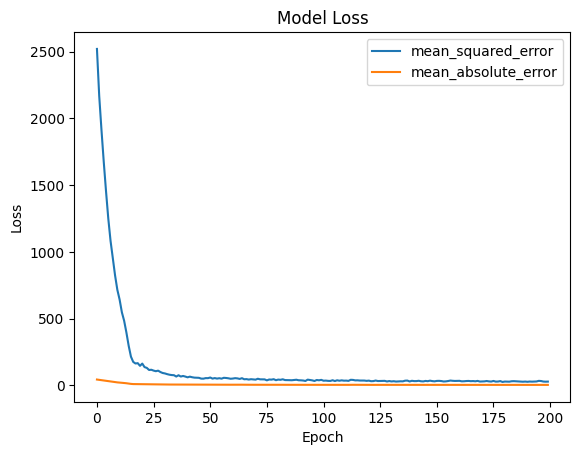

In [31]:
plt.plot(history5.history['mean_squared_error'])
plt.plot(history5.history['mean_absolute_error'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['mean_squared_error','mean_absolute_error'], loc='upper right')
plt.show()

<bound method Layer.get_losses_for of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000021408CFEF70>>